# Algoritmo Harris Corner Detection

En este cuaderno exploraremos el algoritmo Harris, técnica usada para la detección de esquinas en imágenes de una manera efectiva y sencilla computacionalmente. EL metodo se nombre como un descriptor, proporcionando puntos relevantes de cada imagen. Su uso extendido es debido a su simplicidad, efectivida y poco coste computacional. 

A lo largo de este cuaderno veremos paso a paso su funcionamiento y la base de su efectividad.

### Paso1: Cargar y mostrar la imagen de ejemplo

Antes de comenzar, debemos importar las librerías necesarias, cargar la imagen con la que vamos a trabajar y mostrarla para comprobar que la carga ha sido efectiva. Aunque trabajaremos con la imagen en escala de grises, vamos a mostrarla en color.

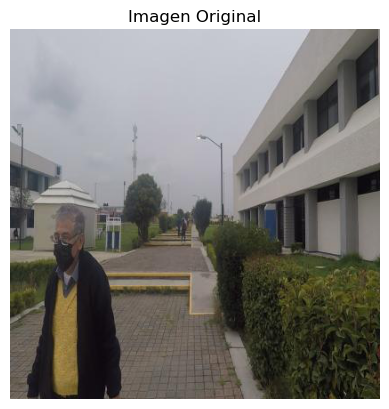

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import algoritmos.harris as hs

img = cv2.imread('../src/images/test/GOPR0141_MP4-195_jpg.rf.5ed66cd884da63e15b570f0db8d88740.jpg',cv2.IMREAD_GRAYSCALE)
img_color = cv2.imread('../src/images/test/GOPR0141_MP4-195_jpg.rf.5ed66cd884da63e15b570f0db8d88740.jpg',cv2.IMREAD_COLOR)
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.title("Imagen Original")
plt.axis("off")
plt.show()

### Paso 2: Convertir la imagen a escala de grises

Aunque ya hemos cargado la imagen en la variable `img` en escala de grises, vamos a explicar el motivo. Lo que percibimos como bordes o esquinas no es más que simples variaciones drasticas de intensidad. Esto aparece reflejado en la matriz de intensidad en RGB o cualquier  espacio de color. Además es muy útil por las siguientes cuestiones:

- **Reducción de complejidad:** Al eliminar el resto de información, reducimos la complejidad sin perder la información estructural que buscamos.
- **Eficiencia computacional:** Al trabajar con un solo canal en lugar de tres, se reduce la carga computacional drásticamente
- **Detección de características:** Los cambios en intensidad es la base de la detección de esquinas en este algoritmo y, el canal que mas información mantiene acerca de los cambios en intensidad, es el gris

Mostramos a continuación la imagen en escala de grises con la que vamos a trabajar. La imagen proviene de un banco de imagen de dominio público y, su elección, ha sido meramente azar.

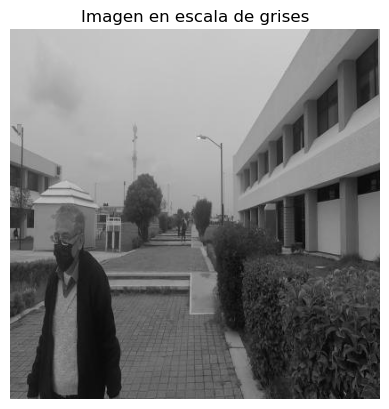

In [20]:

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Imagen en escala de grises")
plt.axis("off")
plt.show()


# Paso 3: Configuración del constructor Harris

En este paso definimos los parámetros que va a usar el algoritmo:

- **gaussbox:** Es el tamaño del kernel usado en el filtro Gaussiano.
- **k:** Es un parámetro de control muy importante. Su valor debe oscilar entre 0.4 y 0.6.
- **threshold:** Es el valor umbral usado para mantener las esquinas más relevantes. En nuestro caso un 5%.
- **window_size:** Es el tamaño del kernel que barre toda la imagen en supresión de no máximos.

Posteriormente, se crea el objeto Harris utilizando la clase definida en el módulo `algoritmos/Harris.py`.

In [21]:
gaussbox=3
k=0.04
threshold=0.05
window_size=5

algo_hs = hs.harris_detect(gaussbox,k,threshold,window_size)

Vamos a explicar el procedimiento que sigue el algoritmo de manera general, y luego lo explicaremos más en detalle. Nos gustaría que este quedara bien explicado y para ello creemos que es conveniente una explicación general, seguida de una más detallada en los proximos pasos.

- **1. Cargamos imagen en escala de grises.**
- **2. Calculamos sus gradientes x e y con un filtro.**
- **3. Calculamos el producto de sus gradientes.**
- **4. Aplicamos un filtro gaussiano a los gradientes.**
- **5. Aplicamos la fórmula que computa las notas Harris.**
- **6. Normalizamos y aplicamos el umbral establecido.**
- **7. Realizamos supresión de no máximos.**

Estos son los pasos del algoritmo.

---

# Paso 4: Calculamos el gradiente de la imagen

Nuestro objetivo final es obtener lo que matemáticamente se dice autovectores. Estos nos indican cuanto y en que dirección varía el dato. En la siguiente imagen podemos ver como varía el valor de estos vectores.

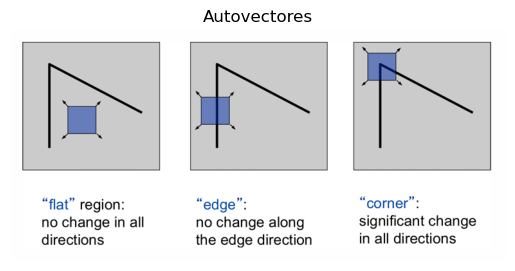

In [22]:
auto = cv2.imread('../src/images/notebook/auto.png',cv2.IMREAD_COLOR)

plt.imshow(cv2.cvtColor(auto, cv2.COLOR_BGR2RGB))
plt.title("Autovectores")
plt.axis("off")
plt.show()

Para el calculo de dichos autovectores debemos satisfacer la siguiente ecuación:

$$
A·x = λx
$$

Donde:
- $A$ es la matriz de autocorrelación de la imagen.
- $x$ es nuestra matriz de autovectores.
- $λ$ es llamado autovalor, es decir cuanto aumenta en cada dirreción el autovector.

Para una matrix $n$ x $n$ existen $n$ autovectores y autovalores.

Los autovalores se obtienen resolviendo:

$$
det(𝐴−𝜆𝐼) =0
$$

$$
det(𝐴 −𝜆𝐼) = det(\begin{bmatrix}
𝑎_{11}−𝜆  , 𝑎_{12} \\ 
𝑎_{21}  , 𝑎_{22}−𝜆 
\end{bmatrix}) = 0
$$

$$
(𝑎_{11}−𝜆)(𝑎_{22}−𝜆)-𝑎_{12}𝑎_{21} = 0
$$

Como es un polinomia de grado 2 podemos obtener fácilmente las respuestas:

$$
𝜆_{max} = \frac{1}{2}  (𝑎_{11} + 𝑎_{22} + \sqrt{4𝑎_{12}𝑎_{21}+(𝑎_{11} - 𝑎_{22})^2})
$$

$$
𝜆_{min} = \frac{1}{2}  (𝑎_{11} + 𝑎_{22} - \sqrt{4𝑎_{12}𝑎_{21}+(𝑎_{11} - 𝑎_{22})^2})
$$

Definimos ahora la fórmula para calcular las notas Harris (Harris and Stephens, 1988) de cada pixel

$$
f(x, y) = 𝜆_{min}𝜆_{max} - κ(𝜆_{min}+𝜆_{max})^2
$$

Nota: El valor **κ** corresponde al valor **k** en la declaraión del constructor

Afotunadamente el valor Harris se puede calcular de esta otra manera:

$$
f(x, y) = det(A) − κ tr(A)^2 = a_{11} a_{22} − a_{12} a_{21} − κ (a_{11} + a_{22})^2
$$

Lo cual es mucho más sencillo y obtenible mediante filtros gradientes como el sobel

---

Una vez explicado la base matemática del algoritmo, realizamos el calculo del gradiente:

$$
∇f(𝑥, 𝑦) = \begin{bmatrix}\frac{\partial f(𝑥,𝑦)}{\partial(𝑥)}, \frac{\partial f(𝑥,𝑦)}{\partial(𝑦)}\end{bmatrix}
$$ 

Ya que el calculo este también es relativamente complejo y costoso podemos realizar que:

$$
 FiltroSobel \approx ∇f(𝑥, 𝑦) = \begin{bmatrix}\frac{\partial f(𝑥,𝑦)}{\partial(𝑥)}, \frac{\partial f(𝑥,𝑦)}{\partial(𝑦)}\end{bmatrix} = \begin{bmatrix}Ix ,Iy\end{bmatrix}  
$$

Nota: el resultado es en realidad una matriz con fx e fy, pero se ha cambiado a Ix e Iy por simplicidad.

El método **calc_grad** aplica un filtro sobel en cada una de las direcciones x e y. Aplicamos el dicho método y obtenemos los siguientes resultados. El resultado no es más que una matriz Ix e Iy con el gradiente de cada pixel.

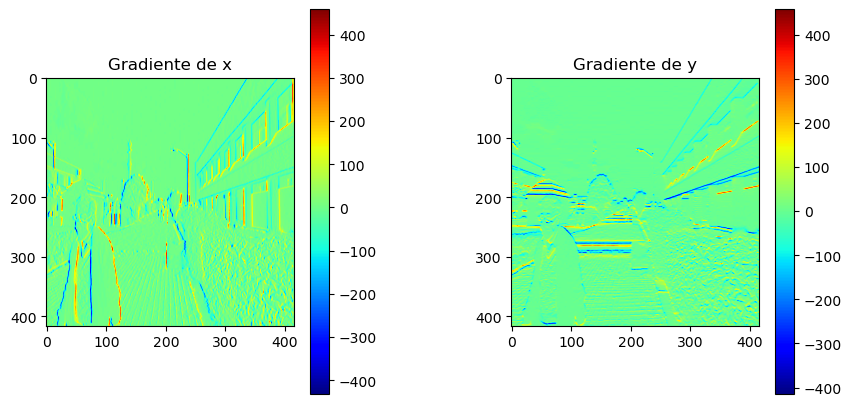

In [23]:
Ix, Iy = algo_hs.calc_grad(img)

plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.imshow(Ix, cmap='jet') 
plt.colorbar()
plt.title("Gradiente de x")

plt.subplot(1,2,2)
plt.imshow(Iy, cmap='jet') 
plt.colorbar()
plt.title("Gradiente de y")

plt.subplots_adjust(wspace=0.5)
plt.show()

# Paso 5: Calculamos la matriz de autocorrelación

El calculo de dicha matriz se computa:

$$
A = \sum_{x,y}{w(x,y)}\begin{bmatrix}Ix^2 , Ixy \\ 
                    Ixy, Iy^2 \end{bmatrix}
 
$$

Para evitarnos usar la función ventana w(x,y), y aprovechando de que ya poseemos los valores Ix e Iy, simplemente obtenemos sus productos. La función calc_grad_prod se encarga de computar el producto de Ix e Iy. el resultado es el mostrado en los mapas de calor.

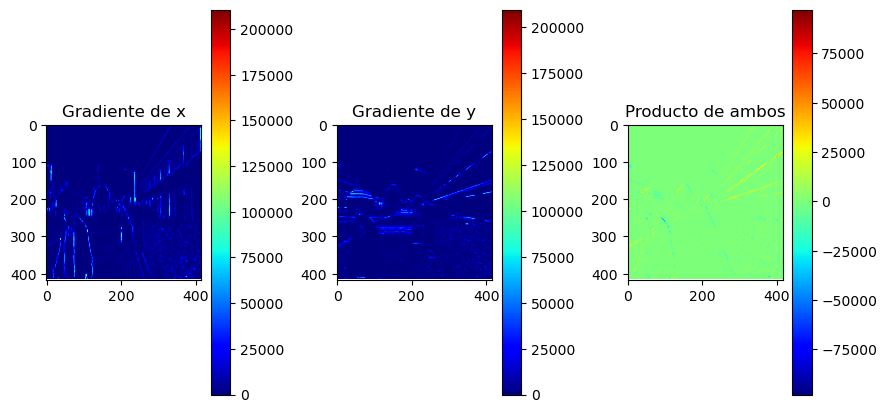

In [24]:
Ix2, Iy2, Ixy = algo_hs.calc_grad_prod(Ix,Iy)

plt.figure(figsize=(10, 5))

plt.subplot(1,3,1)
plt.imshow(Ix2, cmap='jet') 
plt.colorbar()
plt.title("Gradiente de x")

plt.subplot(1,3,2)
plt.imshow(Iy2, cmap='jet') 
plt.colorbar()
plt.title("Gradiente de y")

plt.subplot(1,3,3)
plt.imshow(Ixy, cmap='jet') 
plt.colorbar()
plt.title("Producto de ambos")

plt.subplots_adjust(wspace=0.5)
plt.show()



# Paso 6: Aplicar un suavizado Gaussiano

El siguiente paso es aplicar un filtro gaussiano para suavizar los bordes y obtener mejores resultados. La función gauss_filter realiza este trabajo. Se utilizará como tamaño de kernel el establecido en el constructor (3x3).

- **Objetivo:** El suavizado se usa principalmente para eliminar el ruido de la imagen y, así, evitar que dicho ruido puede llegar a ser percibido como esquina relevante 

Podemos apreciar como se distinguen claramente los bordes del fondo de la imagen.

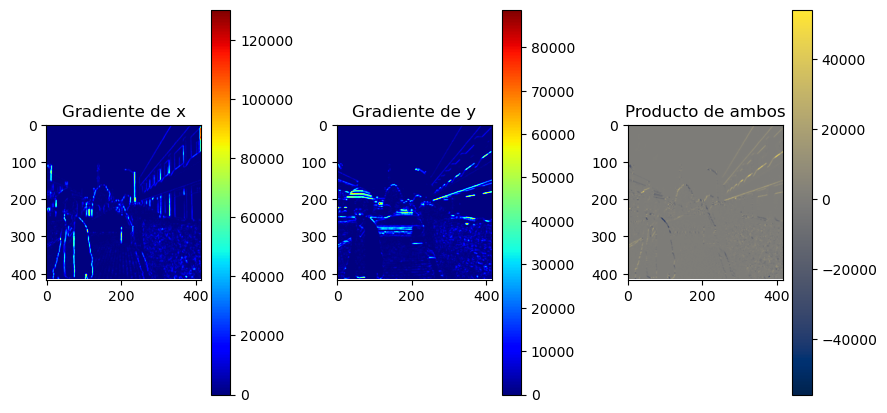

In [25]:
Ix2, Iy2, Ixy = algo_hs.gauss_filter(Ix2, Iy2, Ixy)

plt.figure(figsize=(10, 5))

plt.subplot(1,3,1)
plt.imshow(Ix2, cmap='jet') 
plt.colorbar()
plt.title("Gradiente de x")

plt.subplot(1,3,2)
plt.imshow(Iy2, cmap='jet') 
plt.colorbar()
plt.title("Gradiente de y")

plt.subplot(1,3,3)
plt.imshow(Ixy, cmap='cividis') 
plt.colorbar()
plt.title("Producto de ambos")

plt.subplots_adjust(wspace=0.5)
plt.show()


# Paso 7: Calculamos la nota Harris para cada pixel

Como ya sabemos, la nota Harris para cada pixel (x,y) viene dada por la siguiente fórmula:

$$
f(x, y) = det(A) − κ tr(A)^2
$$

La función que computa dicha fórmula es calc_harris_score, la cual recibe el producto de los gradientes y computa eficientemente dicha nota para cada pixel. Esta nota refleja cuanto "esquina" es un pixel, a mayor nota, mayor relevancia como esquina.

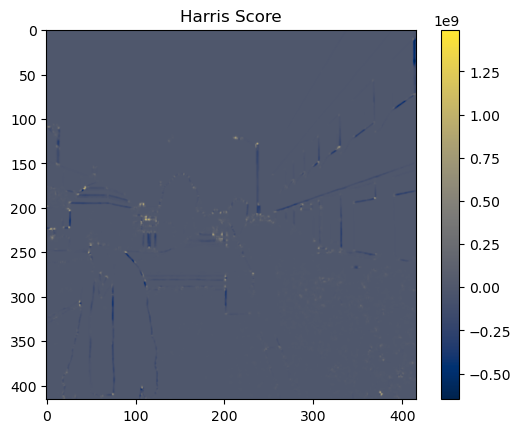

In [26]:
R = algo_hs.calc_harris_score(Ix2, Iy2, Ixy)

plt.imshow(R, cmap='cividis') 
plt.colorbar()
plt.title("Harris Score")
plt.show()

# Paso 8: Normalizamos y aplicamos un umbral

EL siguiente paso es normalizar en un rango [0,255] para trabajar de manera más cómoda, y aplicamos el umbral establecido en el constructor de la clase (normalmente el umbral oscila entre 5%-10%). La clase que computa este caculo es normalize_thresh.

- **1º.** Aplica el umbral. Mantiene a todos los pixel que son mayores que el umbral (Umbral es Max(Notas Harris)*threshold). Esto descarta gran parte de los puntos, ya que como hemos visto antes, existe una gran disparidad de notas entre los que son concebidos como "esquinas" y los que no.
- **2ª.** Normaliza en el rango de [0,255]. Aplica norm_type=cv2.NORM_MINMAX.


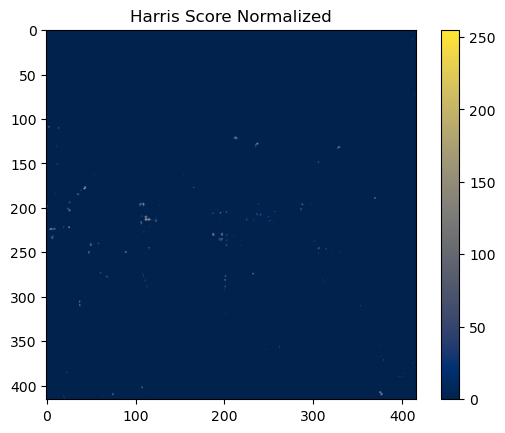

In [27]:
R_norm = algo_hs.normalize_thresh(R)

plt.imshow(R_norm, cmap="cividis") 
plt.colorbar()
plt.title("Harris Score Normalized")
plt.show()

# Paso 8: Aplicar supresión de no maximos

Por último, debemos aplicar supresión de no máximos paro sólo mantener a las esquinas con mayor nota.
Supresión de no máximos consiste en aplicar a la matriz de notas, una funcion ventana que oscila en cada uno de los píxeles, y compara si el valor del píxel central es el mayor de entre sus vecinos.

Explíquemoslo con más detalle:

- Una ventana de tamaño `window_size` recorre por cada píxel de la imagen
- Esta comprueba si el píxel central es el mayor de sus vecinos
- En el caso que sí lo sea, se añade dicho valor a una matriz resultado final. Esto se hace para comparar adecuadamente todos los pixeles con sus vecinos.
- El resultado final es una matriz que contiene solo los píxeles aceptados por la supresión

Este paso permite extraer sólo aquellos píxeles que son los que tiene mayor nota en su vecindario, y por lo tanto, lo que son más suceptibles a ser esquinas viables.

La función draw_corner recibe la matriz final y la recorre. En el caso que el valor de dicha matriz sea distinta a 0, es decir, es una esquina válida, esta dibuja un círculo rojo para poder localizarla más facilmente.

In [29]:
corners = algo_hs.non_max_supre(R_norm)
img2 = algo_hs.draw_corner(corners,img)


# Resultado Final

El resultado final es la imagen original con las esquinas que ha detectado el algoritmo. Este resultado es un descriptor de la imagen y puede ser usado como preprocesamiento de IA para problemas de clasificación y regresión.

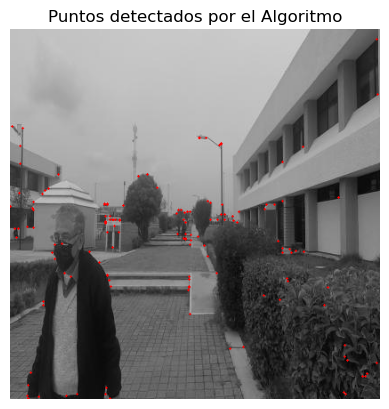

In [30]:
algo_hs.draw_img(img2, 'off')